In [59]:
import folium
import mapclassify
import matplotlib as mpl
import matplotlib.cm
import branca

import shapely
from graphly.api_client import SparqlClient

In [6]:
sparql = SparqlClient("https://lindas.admin.ch/query")

In [83]:
# https://s.zazuko.com/7xVsjp
query = """
PREFIX schema: <http://schema.org/>
PREFIX admin: <https://schema.ld.admin.ch/>
PREFIX locn: <http://www.w3.org/ns/locn#>

SELECT ?thoroughfare ?companies ?geom
FROM <https://lindas.admin.ch/foj/zefix>
FROM <https://lindas.admin.ch/territorial>
WHERE {
  VALUES ?muni {<https://ld.admin.ch/municipality/1711>}
  {
    SELECT ?thoroughfare (COUNT(?sub) AS ?companies)
    WHERE {
        ?sub a admin:ZefixOrganisation ;
          schema:address/locn:thoroughfare ?thoroughfare;
          admin:municipality ?muni.             
    } 
      GROUP BY ?thoroughfare
      ORDER BY ?companies
  }

  SERVICE <https://geo.ld.admin.ch/query> {
      GRAPH <urn:bgdi:boundaries:municipalities> {
        ?muni_swisstopo schema:about ?muni.
      }
      
      GRAPH <urn:bgdi:location:streets> {
        ?street_id a <http://www.opengis.net/ont/geosparql#Feature>;
           schema:name ?thoroughfare;
           schema:containedInPlace ?muni_swisstopo;
           <http://www.opengis.net/ont/geosparql#hasGeometry>/<http://www.opengis.net/ont/geosparql#asWKT> ?geom.
      }
   }
  
}
"""
df = sparql.send_query(query)
df = df.set_crs(epsg=4326)

In [11]:
df.head()

,thoroughfare,companies,geom
0,Bahnhofstrasse,11788,"MULTILINESTRING ((8.51570 47.16802, 8.51571 47..."
1,Dorfstrasse,6268,"MULTILINESTRING ((8.51736 47.16613, 8.51738 47..."
2,Industriestrasse,6212,"MULTILINESTRING ((8.51703 47.17005, 8.51716 47..."
3,Seestrasse,4137,"MULTILINESTRING ((8.51512 47.16802, 8.51505 47..."
4,Baarerstrasse,3735,"MULTILINESTRING ((8.51596 47.17080, 8.51614 47..."


<AxesSubplot:>

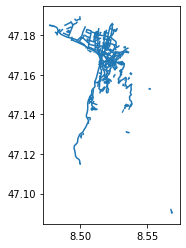

In [12]:
df.plot()

In [101]:
N = 6
classifier = mapclassify.NaturalBreaks(y=df.companies, k=N)
df["bucket"] = df[["companies"]].apply(classifier)

cmap = plt.get_cmap('inferno')
def style_function(feature):
    bucket = df["bucket"].get(int(feature["id"][-5:]), None)
    return {
        "fillOpacity": 0.5,
        "weight": 3,
        "opacity": 1,
        "fillColor": mcolors.rgb2hex(cmap((bucket+1)/N)),
        "color": mcolors.rgb2hex(cmap((bucket+1)/N))
    }


highlight_function = lambda x: {'fillColor': '#989898', 
                                'color':'#989898', 
                                'fillOpacity': 0.8}

In [100]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors




['#320a5e', '#781c6d', '#bc3754', '#ed6925', '#fbb61a', '#fcffa4']

In [102]:
m = folium.Map(location=[47.15, 8.52], zoom_start=13, tiles="CartoDBdark_matter")

hover = folium.features.GeoJson(
    df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['thoroughfare', "companies"],
        aliases=['Street: ', "companies: "],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)

m.add_child(hover)
m.keep_in_front(hover)

title_html = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format("Registered Companies")   
m.get_root().html.add_child(folium.Element(title_html))
m